In [50]:
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
from utils import load_tr_cities, translation, corr_map
warnings.filterwarnings('ignore')

class config:
    train_path = '../../../datasets/garanti-bbva-data-camp/train_users.csv'
    test_path = '../../../datasets/garanti-bbva-data-camp/test_users.csv'
    sub_path = '../../../datasets/garanti-bbva-data-camp/submission.csv'
    skills_path = '../../../datasets/garanti-bbva-data-camp/skills.csv'
    languages_path = '../../../datasets/garanti-bbva-data-camp/languages.csv'
    education_path = '../../../datasets/garanti-bbva-data-camp/education.csv'
    exp_path = '../../../datasets/garanti-bbva-data-camp/work_experiences.csv'
    seed = 42
    n_folds = 6

In [54]:
def load_work_experiences(path: str) -> pd.DataFrame:

    df_ = pd.read_csv(path)
    df_["start_date"] = pd.to_datetime(
        df_["start_year_month"].apply(lambda x: "-".join([str(x)[:4], str(x)[4:]]))
    )
    df_ = df_.drop(columns=["start_year_month"], axis=1)

    df_ = (
        df_.loc[df_["start_date"].dt.year != 2019]
        .sort_values(by=["user_id", "start_date"])
        .reset_index(drop=True)
    )
    df_ = df_.drop_duplicates(subset=["user_id", "company_id"])
    df_["quit_date"] = df_.groupby("user_id")["start_date"].shift(-1)
    df_["days_to_quit"] = (df_["quit_date"] - df_["start_date"]).apply(
        lambda x: np.nan if str(x).split()[0] == "NaT" else int(str(x).split()[0])
    )

    emp_df = (
        df_.groupby(by="user_id", as_index=False)
        .agg(
            employee_lifetime=(
                "start_date",
                lambda x: int(str(pd.to_datetime("2019-01-01") - x.min()).split()[0]),
            ),
            employee_last_experience=(
                "start_date",
                lambda x: int(str(pd.to_datetime("2019-01-01") - x.max()).split()[0]),
            ),
            employee_total_experience=(
                "start_date",
                lambda x: int(str(x.max() - x.min()).split()[0]),
            ),
            employee_last_days_quit=("days_to_quit", "last"),
            employee_min_days_quit=("days_to_quit", "min"),
            employee_max_days_quit=("days_to_quit", "max"),
            employee_std_days_quit=("days_to_quit", "std"),
            employee_med_days_quit=("days_to_quit", "median"),
            employee_last_experience_month=("start_date", lambda x: x.max().month),
            employee_last_experience_year=("start_date", lambda x: x.max().year),
            employee_nunique_company=("company_id", "nunique"),
            company_id=("company_id", "last"),
        )
        .assign(
            employee_avg_days_to_quit=lambda x: x.employee_lifetime
            / x.employee_nunique_company,
            employee_last_experience_month_sin=lambda x: np.sin(
                2 * np.pi * x.employee_last_experience_month / 12
            ),
            employee_last_experience_month_cos=lambda x: np.cos(
                2 * np.pi * x.employee_last_experience_month / 12
            ),
        )
    )

    comp_df = df_.groupby(by="company_id", as_index=False).agg(
        company_avg_days_to_quit=("days_to_quit", "mean"),
        company_std_days_to_quit=("days_to_quit", "std"),
        company_max_days_to_quit=("days_to_quit", "max"),
        company_med_days_to_quit=("days_to_quit", "median"),
        company_skew_days_to_quit=("days_to_quit", "skew"),
        company_nunique_employees=("user_id", "nunique"),
    )

    return emp_df.merge(comp_df, on=["company_id"], how="left").assign(
        avg_days_to_quit_diff=lambda x: x.company_avg_days_to_quit
        - x.employee_avg_days_to_quit,
        avg_days_to_quit_ratio=lambda x: x.company_avg_days_to_quit
        / x.employee_avg_days_to_quit,
    )


In [55]:
#df = load_work_experiences('../../../datasets/garanti-bbva-data-camp/work_experiences.csv')

#df.head(8)

,user_id,employee_lifetime,employee_last_experience,employee_total_experience,employee_last_days_quit,employee_min_days_quit,employee_max_days_quit,employee_std_days_quit,employee_med_days_quit,employee_last_experience_month,...,employee_last_experience_month_sin,employee_last_experience_month_cos,company_avg_days_to_quit,company_std_days_to_quit,company_max_days_to_quit,company_med_days_to_quit,company_skew_days_to_quit,company_nunique_employees,avg_days_to_quit_diff,avg_days_to_quit_ratio
0,0,4870,4870,0,NaN,NaN,NaN,NaN,NaN,9,...,-1.000000e+00,-1.836970e-16,NaN,NaN,NaN,NaN,NaN,5,NaN,NaN
1,2,761,214,547,365.0,182.0,365.0,129.400541,273.5,6,...,1.224647e-16,-1.000000e+00,669.500000,559.321464,1065.0,669.5,NaN,4,415.833333,2.639290
2,5,579,579,0,NaN,NaN,NaN,NaN,NaN,6,...,1.224647e-16,-1.000000e+00,365.000000,NaN,365.0,365.0,NaN,3,-214.000000,0.630397
3,7,914,31,883,883.0,883.0,883.0,NaN,883.0,12,...,-2.449294e-16,1.000000e+00,NaN,NaN,NaN,NaN,NaN,6,NaN,NaN
4,10,1979,245,1734,1734.0,1734.0,1734.0,NaN,1734.0,5,...,5.000000e-01,-8.660254e-01,912.280537,808.719538,5206.0,701.0,1.817045,1410,-77.219463,0.921961
5,11,518,153,365,365.0,365.0,365.0,NaN,365.0,8,...,-8.660254e-01,-5.000000e-01,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN
6,12,2010,61,1949,1096.0,31.0,1096.0,553.019288,822.0,11,...,-5.000000e-01,8.660254e-01,197.277778,114.654881,426.0,212.0,0.129315,36,-305.222222,0.392593
7,13,2863,306,2557,2557.0,2557.0,2557.0,NaN,2557.0,3,...,1.000000e+00,6.123234e-17,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN


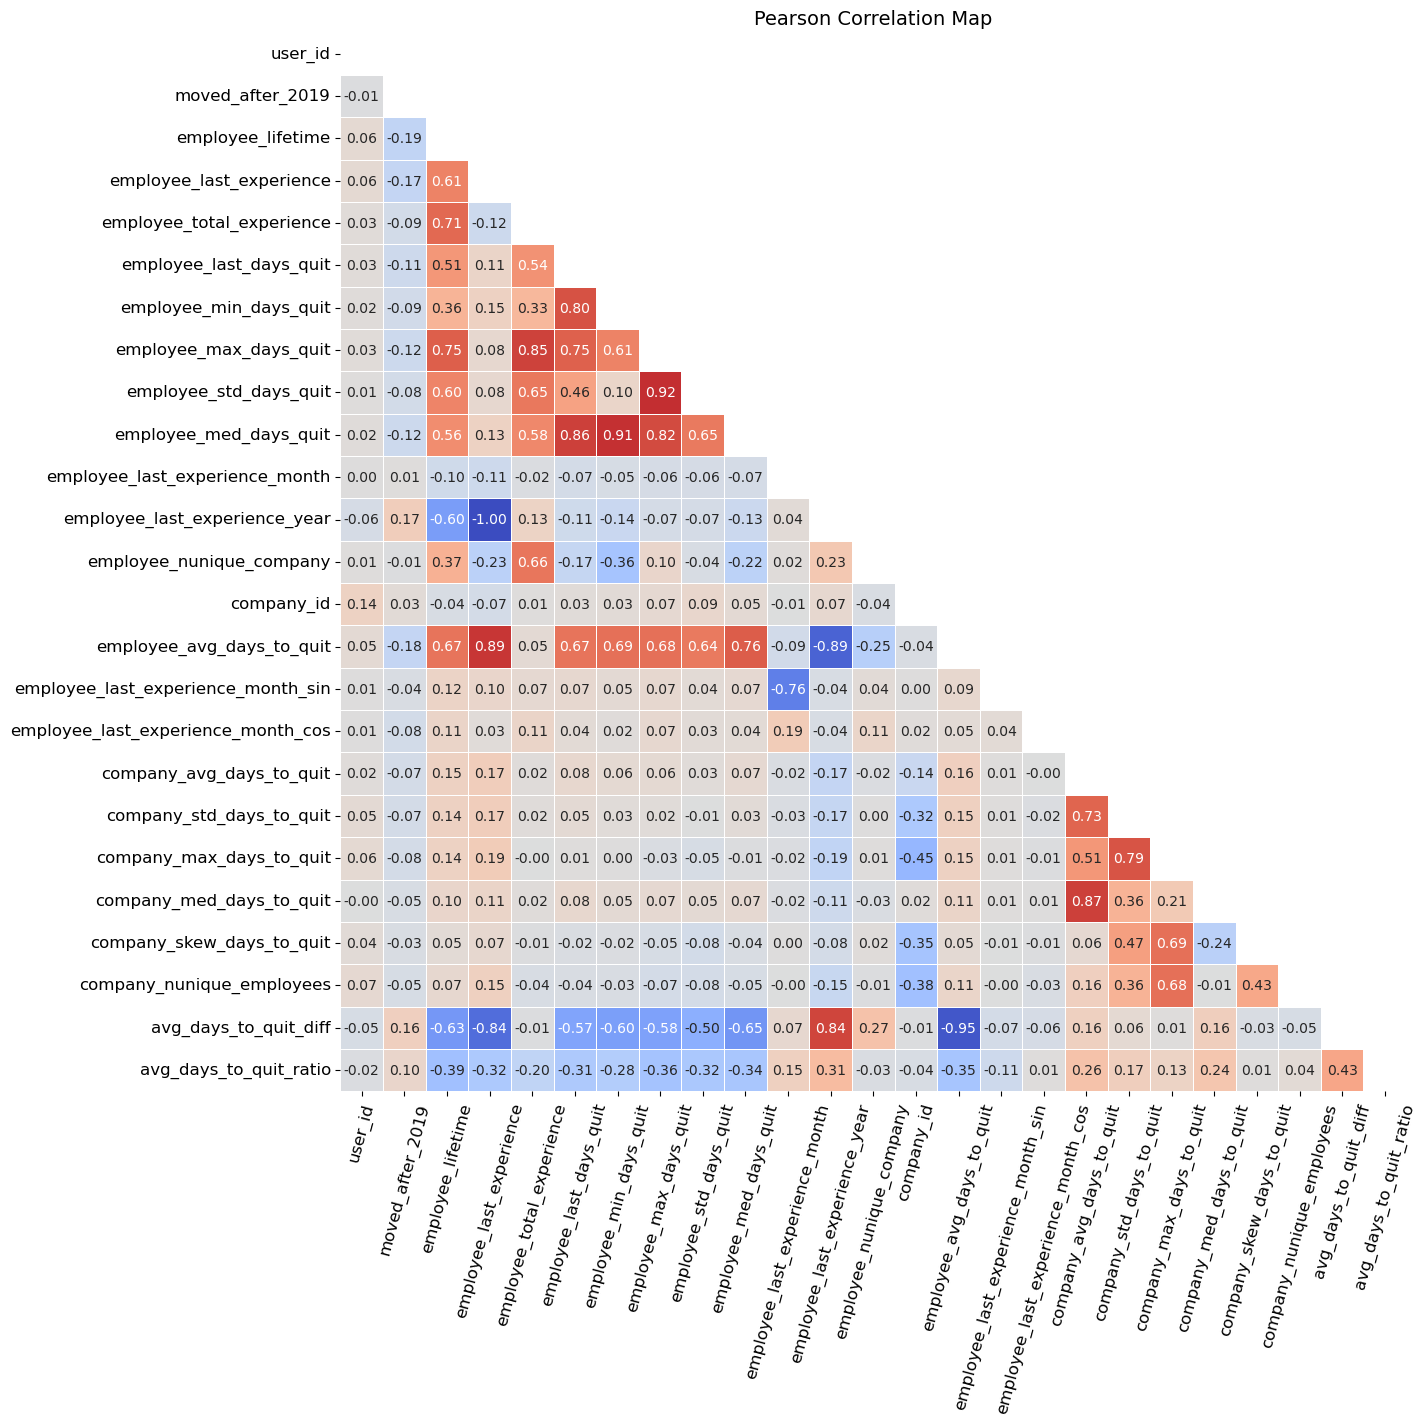

In [57]:
#train = pd.read_csv(config.train_path)

#corr_map(train.merge(df, on = ['user_id'], how = 'left'))

In [41]:
#comp_df = df.drop_duplicates(subset = ['user_id', 'company_id'])
#
#comp_df['quit_date'] = comp_df.groupby('user_id')['start_date'].shift(-1)
#
#comp_df['days_to_quit'] = (comp_df['quit_date'] - comp_df['start_date']).apply(lambda x: np.nan if str(x).split()[0] == 'NaT' else int(str(x).split()[0]))
#
#comp_df

In [42]:
#train_df = pd.read_csv(config.train_path)
#test_df = pd.read_csv(config.test_path)
#sub = pd.read_csv(config.sub_path)
#
#print(f'train_df shape: {train_df.shape}')
#print(f'test_df shape: {test_df.shape}')
#df = train_df.append(test_df).reset_index(drop = True)
#df.loc[df['industry'] == '-1', 'industry'] = np.nan
#df.head()

In [46]:
#train = pd.read_csv(config.train_path)
#
#corr_map(train.merge(df, on = ['user_id'], how = 'left'))

In [ ]:
#corr_map(df)

In [ ]:
#emp_df = df.groupby(by = "user_id", as_index=False).agg(
#        employee_lifetime=(
#            "start_date",
#            lambda x: int(str(pd.to_datetime("2019-01-01") - x.min()).split()[0]),
#        ),
#        employee_last_experience=(
#            "start_date",
#            lambda x: int(str(pd.to_datetime("2019-01-01") - x.max()).split()[0]),
#        ),
#        employee_total_experience=(
#            "start_date",
#            lambda x: int(str(x.max() - x.min()).split()[0]),
#        ),
#        employee_last_experience_month=("start_date", lambda x: x.max().month),
#        employee_last_experience_year=("start_date", lambda x: x.max().year),
#        employee_last_company_id = ('company_id', 'last'),
#        employee_nunique_company = ('company_id', 'nunique'),
#    ).assign(
#        employee_avg_days_to_quit = lambda x: x.employee_lifetime / x.employee_nunique_company
#    )
#
#emp_df
#

In [ ]:
#emp_df.groupby('user_id')['days_to_quit'].shift(1).isnull().sum()

In [ ]:
#df.groupby(by = 'company_id', as_index=False).agg(company_avg_days_to_quit = ('days_to_quit', 'mean'))

In [ ]:
#df.groupby('user_id').agg(total_experience = ('start_date', lambda x: int(str(pd.to_datetime('2019-01-01') - x.min()).split()[0]))).merge(
#
#    df.groupby('user_id').agg(unique_company = ('company_id', 'nunique')), on = ['user_id'], how = 'left'
#
#).reset_index().assign(avg_days_to_quit = lambda x: x.total_experience / x.unique_company)

In [ ]:
#df.loc[df['location'].astype(str).str.contains('tekno'), 'location'].value_counts()[:20]

In [ ]:
#df.loc[(df['location'].astype(str).str.contains('Kemalpaşa')) & (~df['location'].astype(str).str.contains('aa')), 'location'].value_counts().keys().tolist()

In [ ]:
#df_.loc[df_['location'] =='Intern', 'location'] = np.nan
#df_.loc[df_['location'] =='Stajyer', 'location'] = np.nan
#df_.loc[df_['location'] =='Sales Consultant', 'location'] = np.nan
#df_.loc[df_['location'] =='asistan', 'location'] = np.nan
#df_.loc[df_['location'] =='Yazılım stajyeri', 'location'] = np.nan
#df_.loc[df_['location'] =='stajer mühendis', 'location'] = np.nan
#df_.loc[df_['location'] =='stajyer mühendis', 'location'] = np.nan
#df_.loc[df_['location'] =='Yazılım stajı', 'location'] = np.nan
#df_.loc[df_['location'] =='Donanım stajı', 'location'] = np.nan
#df_.loc[df_['location'] =='staj', 'location'] = np.nan    
#df_.loc[df_['location'] =='stajer', 'location'] = np.nan
#df_.loc[df_['location'] =='stajyer', 'location'] = np.nan
#df_.loc[df_['location'] =='User support application specialist', 'location'] = np.nan
#df_.loc[df_['location'] =='front-end developer', 'location'] = np.nan
#df_.loc[df_['location'] =='Kasa Personeli', 'location'] = np.nan
#df_.loc[df_['location'] =='web developer', 'location'] = np.nan
#df_.loc[df_['location'] =='Software development', 'location'] = np.nan
#df_.loc[df_['location'] =='Software developer', 'location'] = np.nan
#df_.loc[df_['location'] =='software developer', 'location'] = np.nan
#df_.loc[df_['location'] =='Visual Studio Asp.Net Developer', 'location'] = np.nan
#df_.loc[df_['location'] == 'yazılım mühendisi', 'location'] = np.nan
#df_.loc[df_['location'] == 'Supervisor chief engineer', 'location'] = np.nan
#df_.loc[df_['location'] == 'Computer Engineer (System Administrator-Specialist)', 'location'] = np.nan
#df_.loc[df_['location'] == 'Civil Engineer', 'location'] = np.nan
#df_.loc[df_['location'] == 'Öğrenci stajeri', 'location'] = np.nan
#df_.loc[df_['location'] == 'İzmir Yüksek Teknoloji Enstitüsü Teknopark', 'location'] = 'Izmir, Turkey'
#df_.loc[df_['location'] == 'İstanbul/Avrupa', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'Sakarya Arifiye', 'location'] = 'Sakarya, Turkey'
#df_.loc[df_['location'] == 'Kepez, Çanakkale, Türkiye', 'location'] = 'Canakkale, Turkey'
#df_.loc[df_['location'] == 'Ataşehir', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'atasehir', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'Muğla milas', 'location'] = 'Mugla, Turkey'
#df_.loc[df_['location'] == 'Besiktas', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'Istanbu', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'Ataşehir', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'İçerenköy Mh. Karaman Çiftlik Yolu Cd. Firuze Sk. Secretcv Plaza No:2 Ataşehir', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'Kahraman Maras, Turkey', 'location'] = 'Kahramanmaras, Turkey'
#df_.loc[df_['location'] == 'Pendik', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'Pendik Teknopark', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'Levent', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'Levent,Davutpaşa', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'Levent, Kolektif House', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'Kolektif House | Levent', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'Samandıra/Kadıköy/Levent', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'Beşiktaş', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'Beşiktaş/Akatlar', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'Fulya Beşiktaş', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'Ulus/Beşiktaş', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'Beşiktaş Barbaros', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'İçerenköy', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'İçerenköy Üner Plaza', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'Kağıthane', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'Bostancı', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'Ümraniye', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'Ümraniye ', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'Netaş HQ Ümraniye', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'Mecidiyeköy', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'Sarıyer', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'Şişli', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'Esentepe Şişli İst', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'Esentepe / Sisli', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'Kadıköy', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'Beşiktaş - Kadıköy', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'beşiktaş', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'Avcılar', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'avcılar', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'Avcılar Teknopark', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'pendik', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'Beyoğlu', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'Beyoğlu, Galata', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'Karaköy', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'bostancı ebebek', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'bostancı ', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == '4.levent', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'ista', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'ist', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'İst', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'Çekmeköy', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'çekmeköy', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'nişantaşı', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'ataşehir', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'Batı ataşehir', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'Taksim', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'Kadıköy/Fenerbahçe', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'Göztepe', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'Ortaköy', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'Yıldız teknik üniversitesi teknopark', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'yıldız teknik üniversitesi teknopark', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'ytü teknopark', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'Davutpaşa YTU teknopark', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'Yıldız teknopark ', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'ytu davutpasa teknopark', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'Gebze', 'location'] = 'Kocaeli, Turkey'
#df_.loc[df_['location'] == 'Maslak', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'İTÜ Maslak Kampüsü', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'Maslak, Turkey', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'Acıbadem', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'Acıbadem genel müdürlük', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'Acıbadem/ Anadolu Yakası Bölge Müdürlüğü', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'Üsküdar', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'Dudullu', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'Dudullu ', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'Dudullu OSB 2. Cadde No:4', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'Buyaka Tower-2, Ümraniye / İSTANBUL', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'Ümraniye / Turkey', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'Ümraniye,Turkey', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'Yukarı Dudullu- Ümraniye / İSTANBUL', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'Ümraniye / Gebze', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'Adres: Fatih Sultan Mehmet. Mah. Balkan Cad. No: 47 Casper Plaza, Ümraniye / İst', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'Yukarı Dudullu Organize Sanayi Bölgesi,  And Sitesi, No:18 34775 Ümraniye / İST.', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'kadıköy', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'moda, kadıköy', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'dudullu', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'YTÜ Beşiktaş / İSTANBUL', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'Beşiktaş, Türkiye', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'Beştepe Mah., Ankara, Türkiye', 'location'] = 'Ankara, Turkey'
#df_.loc[df_['location'] == 'Beşiktaş ', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'Kemalpaşa', 'location'] = 'Izmir, Turkey'
#df_.loc[df_['location'] == 'Kemalpaşa Organize Sanayi Bölgesi - ITOB', 'location'] = 'Izmir, Turkey'
#df_.loc[df_['location'] == 'Göztepe, Bağdat Caddesi', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'Göztepe Yerleşkesi', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'Göztepe Kampüsü', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'Marmara University, Göztepe', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'Marmara Üniversitesi', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'Yıldız Teknik Üniversitesi', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'Yıldız Teknik Üniversitesi Teknopark', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'Yıldız Technical University Technopark', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'İstanbul Technical University - Technocity', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'Yeditepe University', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'Yildiz Technical University R&D Lab', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'Istanbul University-Cerrahpasa, Engineering Faculty', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'Teknopark Yıldız Teknik Üniversitesi', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'Yıldız Teknik University', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'Yıldız Teknik Üniversitesi TeknoPark', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'Istanbul Technical University IT Head Office ', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'İstanbul Üniversitesi - Cerrahpaşa Mühendislik Fakültesi', 'location'] = 'Istanbul, Turkey'
#df_.loc[df_['location'] == 'Yıldız Teknik Üniversitesi - Teknopark', 'location'] = 'Istanbul, Turkey'